In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/data/"

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [3]:
import os
import numpy as np
import gzip
import matplotlib.pyplot as plt

In [11]:
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape(-1, 28*28)
    return flattened_pixels

def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

images = read_pixels("/content/drive/MyDrive/data/train-images-idx3-ubyte.gz")
labels = read_labels("/content/drive/MyDrive/data/train-labels-idx1-ubyte.gz")

In [17]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
f = images.reshape(images.shape[0], -1)
len(f)

60000

In [22]:
mean_pixel = np.mean(images, axis=0)
centered_data = images - mean_pixel

cov_matrix = np.cov(centered_data, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

total_variance = np.sum(eigenvalues)
pve = eigenvalues / total_variance

print("Proportion of Variance Explained (PVE) for the first 10 principal components:")
for i in range(10):
    print(f"PC-{i + 1}: {pve[i]}")


Proportion of Variance Explained (PVE) for the first 10 principal components:
PC-1: 0.09704664368150995
PC-2: 0.07095924066613629
PC-3: 0.06169088772849623
PC-4: 0.05389419494309184
PC-5: 0.04868797012682377
PC-6: 0.043122313233494455
PC-7: 0.032719299513236835
PC-8: 0.028838954483044483
PC-9: 0.02762029396742113
PC-10: 0.023570005511596343


In [24]:
cum_vars = np.cumsum(pve)
num_components_needed = np.argwhere(cum_vars >= 0.70)[0,0] + 1

print(f"Number of principal components needed to explain at least {0.70 * 100:.2f}% of the data: {num_components_needed}")


Number of principal components needed to explain at least 70.00% of the data: 26


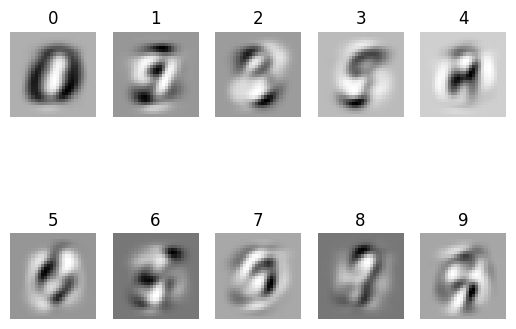

In [26]:
scaled_components = []
for i in range(10):
    principal_component = eigenvectors[:, i].reshape(28, 28)
    scaled_component = (principal_component - np.min(principal_component)) / (np.max(principal_component) - np.min(principal_component))
    scaled_components.append(scaled_component)

for i, component in enumerate(scaled_components):
    plt.subplot(2, 5, i+1)
    plt.imshow(component, cmap='Greys_r')
    plt.title(f'{i}')
    plt.axis('off')
plt.show()

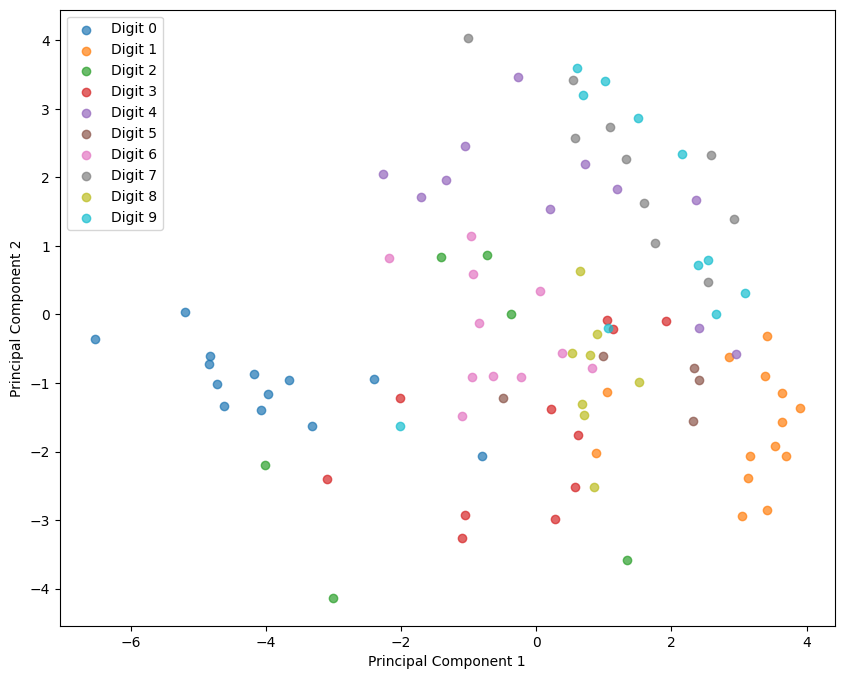

In [15]:
projected_data = np.dot(centered_data[:100], eigenvectors)

plt.figure(figsize=(10, 8))
for label in range(10):
    indices = np.where(labels[:100] == label)[0]
    plt.scatter(projected_data[indices, 0], projected_data[indices, 1], label=f'Digit {label}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend()

plt.show()


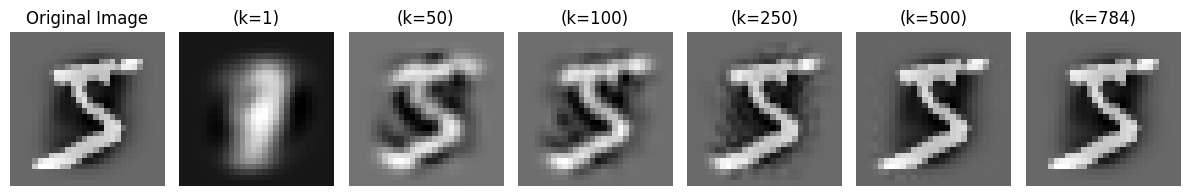

In [16]:
def reconstruct_image(original_image, k, eigenvectors, mean_pixel):
    centered_image = original_image - mean_pixel

    projection = np.dot(eigenvectors[:, :k].T, centered_image)

    reconstructed_image = np.dot(eigenvectors[:, :k], projection) + mean_pixel

    return reconstructed_image

k_values = [1, 50, 100, 250, 500, 784]

plt.figure(figsize=(12, 4))
plt.subplot(2, len(k_values) + 1, 1)
original_image = centered_data[0].reshape(28, 28)
plt.imshow(original_image, cmap='Greys_r')
plt.title('Original Image')
plt.axis('off')

for i, k in enumerate(k_values):
    reconstructed_image = reconstruct_image(centered_data[0], k, eigenvectors, mean_pixel)

    plt.subplot(2, len(k_values) + 1, i + 2)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='Greys_r')
    plt.title(f'(k={k})')
    plt.axis('off')

plt.tight_layout()
plt.show()
